# Visualising Networks
If you've read the [Intro to Bookworm notebook](Intro to Bookworm.ipynb), you should have a decent understanding of how Bookworm assembles a list of character relationships and assesses their strength.  
The real point of this project, though, is to give the user a more tactile, intuitive view of the network of characters and how they interact. This notebook should cover the methods I've used to achieve that.

Let's start by importing all the usual stuff and loading in the Harry Potter network:

In [1]:
import utils
from utils import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,9)

import pandas as pd
import numpy as np

In [3]:
book = load_book('../data/raw/hp.txt')
characters = load_characters('../data/raw/characters_hp.csv')
sequences = get_character_sequences(book)

hash_to_sequence, sequence_to_hash = get_sequence_hashes(sequences)
hash_to_character, character_to_hash = get_character_hashes(characters)

df = find_connections(sequences, characters)
cooccurence = calculate_cooccurence(df).to_sparse()

## Visualisation with NetworkX
NetworkX is a very nice python library which is built to handle graphs and networks. We can load our data into a NetworkX `Graph` object by building up a table of interactions and interactions as follows:

In [4]:
import networkx as nx

interaction_df = pd.DataFrame([[str(c1), 
                                str(c2), 
                                cooccurence[hash(c1)][hash(c2)]]
                               for c1 in characters
                               for c2 in characters],
                              columns=['source', 'target', 'value'])

interaction_df.sample(5)

,source,target,value
17957,"('elfric the eager ',)","('dudley ', ' duddy ')",0
1285,"('dumbledore ', ' albus ')","('paracelsus ',)",0
7308,"('george ',)","('snowy ',)",0
2249,"('figg ',)","('morag macdougal ',)",0
11327,"('terry boot ',)","('katie bell ',)",0


There's a lot of useless junk in there, so lets cut out all interactions with values less than 2

In [5]:
interaction_df = interaction_df[interaction_df['value'] > 2]
interaction_df.sample(5)

,source,target,value
724,"('harry ', ' potter ')","('ollivander ',)",8
749,"('harry ', ' potter ')","('hermione ', ' granger ')",76
5609,"('quirrell ',)","('hermione ', ' granger ')",3
688,"('harry ', ' potter ')","('hagrid ', ' rubeus ')",77
788,"('harry ', ' potter ')","('fang ',)",4


We can now load that interaction dataframe into a NetworkX Graph using the super simple `from_pandas_dataframe()` function:

In [6]:
G = nx.from_pandas_dataframe(interaction_df,
                             source='source',
                             target='target')

And, just as easily, visualise it with `draw_spring()`, where spring is a reference to the idea that edges in the network are treated like physical springs, with elasticity/compressability related to the weights of the connections:

/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/harrisonpim/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnin

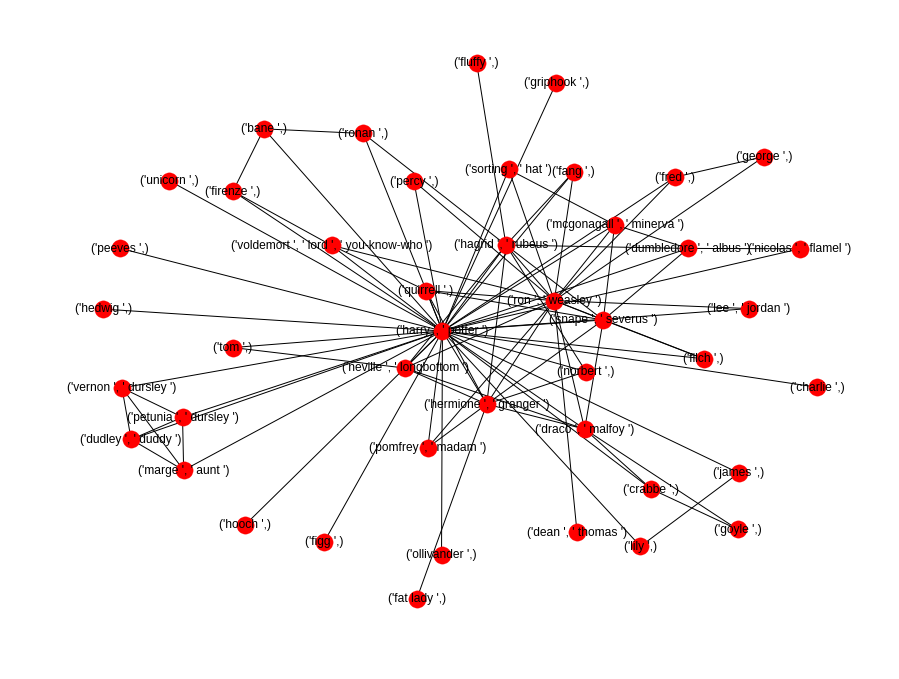

In [7]:
nx.draw_spring(G, with_labels=True)
#plt.savefig('graph')

Very nice... ish. There's more that could be done to clean up the visualisation and make it pretty, but it's fine for now.

One of the nicest things about NetworkX is all of its builtin network analysis functionality. For example, we can use `pagerank` or `hits` to give us the most 'important' or 'central' nodes in the network. These algorithms were originally developed to analyse linked networks of websites, but they can just as easily be applied to stations in transport networks, streets in cities, similar products in ecommerce systems, friends in social circles, or connected characters in books.

In [8]:
pd.Series(nx.pagerank(G)).sort_values(ascending=False)[:5]

('harry ', ' potter ')        0.192625
('ron ', ' weasley ')         0.084375
('hagrid ', ' rubeus ')       0.047885
('hermione ', ' granger ')    0.047091
('snape ', ' severus ')       0.040682
dtype: float64

In [9]:
a, b = nx.hits(G)
pd.Series(a).sort_values(ascending=False)[:5]

('harry ', ' potter ')        0.099945
('ron ', ' weasley ')         0.066904
('hermione ', ' granger ')    0.048614
('snape ', ' severus ')       0.047971
('hagrid ', ' rubeus ')       0.046038
dtype: float64

We can ask NetworkX for cliques in the graph, which are especially relevant to social networks like this. `enumerate_all_cliques()` gives us a massive list of all the cliques it finds - we'll just return the last one because it's most illustrative of what a clique is in this context...

In [10]:
list(nx.enumerate_all_cliques(G))[-1]

["('harry ', ' potter ')",
 "('petunia ', ' dursley ')",
 "('marge ', ' aunt ')",
 "('dudley ', ' duddy ')",
 "('vernon ', ' dursley ')"]

It's isolated the people who appear in the book at Number 4, Privet Drive. Fun!

We can do stuff like illustrate the communicability of one character with another - We would expect that characters which don't spend much time together in the book would have a harder time communicating with one another than those who spend a lot of time together, illustrated by a smaller communicability value:

In [11]:
comms = nx.communicability(G)

print(comms["('griphook ',)"]["('fluffy ',)"])
print(comms["('harry ', ' potter ')"]["('ron ', ' weasley ')"])

9.613733696515919
1064.0667908770415


Similarly, we can use NetworkX's implementation of classic pathfinding algoritms like _Dijkstra's algorithm_ and _A\*_ to return paths between characters. For example, if Griphook was interested in getting to know Fluffy, and wanted to do so with as few new introductions as possible along the way, these are the shoulders he would need to tap on for introductions:

In [12]:
nx.dijkstra_path(G, 
                 source="('griphook ',)", 
                 target="('fluffy ',)")

["('griphook ',)",
 "('harry ', ' potter ')",
 "('hagrid ', ' rubeus ')",
 "('fluffy ',)"]

Pathfinding is clearly an application that is more suited to transport networks, but it's still interesting to see it applied here...  
There's an anecdote which gets passed around about a young South Korean computer scientist in academia who wanted to rise to the top of his field as quickly as possible. By developing a network of the academics in his field and their people they had published with, he was able to quickly work out which authors were most influential, and the path of introductions and cooautorship that he would need to take from his own, weak position in the network to publishing papers with the most influencial academics and becoming a central node himself. I have no idea whether the anecdote is true or not, but it's a nice story, and illustrative of where and why this stuff might be useful to think about. Applying it to goblins and three-headed dogs is fun, but it can be useful in the real world too...

All of this stuff dates back to the 1730s and the origins of graph theory, with Euler and the [Seven Bridges of Konigsberg](https://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg). It's a subject worth reading about if you haven't already - it's fascinating, and the world opens up to you in entirely new ways when you develop some intuition around when and where networks appear in nature and how they can be analysed. Clever applications of graph theory are absolutely key to the success of companies like Google, Facebook, and Amazon.

# More dynamic visualisations with d3.js
The thing above is fast and fun, and allows us to run a load of interesting algorithms over the network, but it all feels very static... The point of this project is to visualise these networks in an way which gives the user an intuitive sense of the relationships between characters.  
We can get closer to that intuitive, touchy-feely sense of the network by putting together a force directed graph with d3.js, like the one by Mike Bostock (the creatory of d3) shown [here](https://bl.ocks.org/mbostock/4062045). Bostock is visualising the boring old Les Mis dataset - we're going to feed d3 our freshly made Harry Potter one.

First we need to set up the data structure which the d3 script requires.

In [13]:
d3_dict = {'nodes': [{"id": str(id), "group": 1} for id in set(interaction_df['source'])], 
           'links': interaction_df.to_dict(orient='records')}

We can write that dictionary out to a `.json` file in the project's [d3 directory](../src/d3) using the json package:

In [14]:
import json

with open('../src/d3/bookworm.json', 'w') as fp:
    json.dump(d3_dict, fp)

Jupyter notebooks allow us to run commands in other languages, so we'll use `bash` to do a few things from here on. For example, we can list the files in the d3 directory:

In [15]:
%%bash
ls ../src/d3/

bookworm.json
index.html


or print out one of those files:

In [16]:
%%bash
cat ../src/d3/index.html

<!DOCTYPE html>
<meta charset="utf-8">
<style>

.links line {
  stroke: #999;
  stroke-opacity: 0.6;
}

.nodes circle {
  stroke: #fff;
  stroke-width: 1.5px;
}

</style>
<svg width="2000" height="1000"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>
<script>

var svg = d3.select("svg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

var color = d3.scaleOrdinal(d3.schemeCategory20);

var simulation = d3.forceSimulation()
    .force("link", d3.forceLink().id(function(d) { return d.id; }))
    .force("charge", d3.forceManyBody())
    .force("center", d3.forceCenter(width / 2, height / 2));

d3.json("./bookworm.json", function(error, graph) {
  if (error) throw error;

  var link = svg.append("g")
      .attr("class", "links")
    .selectAll("line")
    .data(graph.links)
    .enter().append("line")
      .attr("stroke-width", function(d) { return Math.sqrt(d.value); });

  var node = svg.append("g")
      .attr("class", "nodes")
    .selectAll("circle")
 

The next cell can be used to set up a locally hosted version of that d3.js script. 

It's a super-simple, two-line bash script which uses python's builtin `http.server` module to run the javascript visualisation code in the browser on your machine. 

We dumped our graph data into a file called `'bookworm.json'` in one of the cells above - that file can now processed by `'index.html'` (printed above), which displays the data using the `d3.js` javascript library.

In [17]:
%%bash
cd ../src/d3/ 
python -m http.server

Traceback (most recent call last):
  File "/home/harrisonpim/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/harrisonpim/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/harrisonpim/anaconda3/lib/python3.5/http/server.py", line 1221, in <module>
    test(HandlerClass=handler_class, port=args.port, bind=args.bind)
  File "/home/harrisonpim/anaconda3/lib/python3.5/http/server.py", line 1194, in test
    httpd = ServerClass(server_address, HandlerClass)
  File "/home/harrisonpim/anaconda3/lib/python3.5/socketserver.py", line 440, in __init__
    self.server_bind()
  File "/home/harrisonpim/anaconda3/lib/python3.5/http/server.py", line 138, in server_bind
    socketserver.TCPServer.server_bind(self)
  File "/home/harrisonpim/anaconda3/lib/python3.5/socketserver.py", line 454, in server_bind
    self.socket.bind(self.server_address)
OSError: [Errno 98] Address already in use


When you've run the cell, open a new tab and go to the following address 

`localhost:8000`

You should see a pretty graph representation of our network bouncing around. Hover over a node to see which character it corresponds to. Click and drag nodes to play around with it (This is super fun to do with your hands if you're running this on a touchscreen laptop. Playing with two hands also works!).

### Note:
When you're finished playing, remember to navigate back to the two-line `%%bash` cell above and push the **STOP** button to kill the local server. You won't be able to run any more code in this notebook until you do.